# Sortino Ratio: Focusing on Downside Risk

**Time:** 12 minutes

**Prerequisites:** 05_sharpe_ratio.ipynb

---

The Sharpe Ratio treats all volatility as equally bad. But is upside volatility (making more than expected) really a problem? The **Sortino Ratio** addresses this by only penalizing **downside** volatility.

## The Problem with Sharpe Ratio

**Sharpe Ratio's Assumption:** All volatility is bad.

**Reality:** Investors don't mind upside surprises!

**Example:**
- Stock A: +10%, +12%, +8%, +11%, +9% (low volatility, all positive)
- Stock B: +5%, +25%, +3%, +20%, +7% (high volatility, but all positive!)

Stock B has higher volatility, so it has a *lower* Sharpe Ratio. But should it be penalized for volatile gains?

**The Sortino Ratio solves this** by only counting downside moves as risk.

## Sortino Ratio Formula

$$\text{Sortino Ratio} = \frac{R_p - R_{target}}{\sigma_{downside}}$$

Where:
- $R_p$ = Portfolio return
- $R_{target}$ = Target or minimum acceptable return (often 0 or risk-free rate)
- $\sigma_{downside}$ = Downside deviation (standard deviation of returns below target)

**Downside Deviation Formula:**

$$\sigma_{downside} = \sqrt{\frac{1}{n_{down}} \sum \min(R_i - R_{target}, 0)^2}$$

**Key Difference from Sharpe:**
- Sharpe uses total standard deviation (all returns)
- Sortino uses only returns **below** the target

In [1]:
# Install required packages
!pip install -q yfinance pandas numpy matplotlib

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_downside_deviation(returns, target_return=0):
    """Calculate downside deviation.

    Args:
        returns: Series of returns
        target_return: Minimum acceptable return (default 0)

    Returns:
        Downside deviation
    """
    # Get returns below target
    downside_returns = returns - target_return
    downside_returns = downside_returns[downside_returns < 0]

    # Calculate downside deviation
    if len(downside_returns) == 0:
        return 0

    # Square the negative returns, take mean, then sqrt
    downside_squared = downside_returns ** 2
    downside_dev = np.sqrt(downside_squared.mean())

    return downside_dev

def calculate_sortino_ratio(returns, target_return=0, periods_per_year=252):
    """Calculate the Sortino Ratio.

    Args:
        returns: Series of returns (daily)
        target_return: Minimum acceptable return (daily, default 0)
        periods_per_year: Trading days per year

    Returns:
        Dictionary with Sortino ratio and components
    """
    # Calculate excess return over target
    excess_return = returns.mean() - target_return
    annualized_excess = excess_return * periods_per_year

    # Calculate downside deviation
    downside_dev = calculate_downside_deviation(returns, target_return)
    annualized_downside = downside_dev * np.sqrt(periods_per_year)

    # Sortino ratio
    sortino = annualized_excess / annualized_downside if annualized_downside > 0 else np.inf

    # Also calculate Sharpe for comparison
    total_vol = returns.std() * np.sqrt(periods_per_year)
    sharpe = annualized_excess / total_vol if total_vol > 0 else np.inf

    return {
        'sortino_ratio': sortino,
        'sharpe_ratio': sharpe,
        'annualized_return_pct': (returns.mean() * periods_per_year) * 100,
        'annualized_volatility_pct': total_vol * 100,
        'downside_deviation_pct': annualized_downside * 100,
        'n_negative_days': (returns < target_return).sum(),
        'n_total_days': len(returns),
        'pct_negative_days': (returns < target_return).sum() / len(returns) * 100
    }

# Example: Calculate Sortino for a stock
ticker = "AAPL"
stock = yf.Ticker(ticker)
hist = stock.history(period="2y")
returns = hist['Close'].pct_change().dropna()

result = calculate_sortino_ratio(returns)

print(f"Sortino Ratio Analysis: {ticker}")
print("=" * 50)
print(f"Annualized Return:       {result['annualized_return_pct']:>8.1f}%")
print(f"Total Volatility:        {result['annualized_volatility_pct']:>8.1f}%")
print(f"Downside Deviation:      {result['downside_deviation_pct']:>8.1f}%")
print("-" * 50)
print(f"Sharpe Ratio:            {result['sharpe_ratio']:>8.2f}")
print(f"Sortino Ratio:           {result['sortino_ratio']:>8.2f}")
print("-" * 50)
print(f"Negative Days:           {result['n_negative_days']:>8} ({result['pct_negative_days']:.1f}%)")
print(f"\nInterpretation:")
if result['sortino_ratio'] > result['sharpe_ratio']:
    print(f"  Sortino > Sharpe means more upside volatility than downside.")
    print(f"  This stock has favorable asymmetry!")
else:
    print(f"  Sortino < Sharpe means more downside volatility than upside.")
    print(f"  This stock has unfavorable asymmetry.")

Sortino Ratio Analysis: AAPL
Annualized Return:           22.7%
Total Volatility:            28.1%
Downside Deviation:          27.5%
--------------------------------------------------
Sharpe Ratio:                0.81
Sortino Ratio:               0.83
--------------------------------------------------
Negative Days:                224 (44.9%)

Interpretation:
  Sortino > Sharpe means more upside volatility than downside.
  This stock has favorable asymmetry!


## Visualizing Upside vs Downside

Let's see the return distribution and how Sortino only penalizes the left tail.

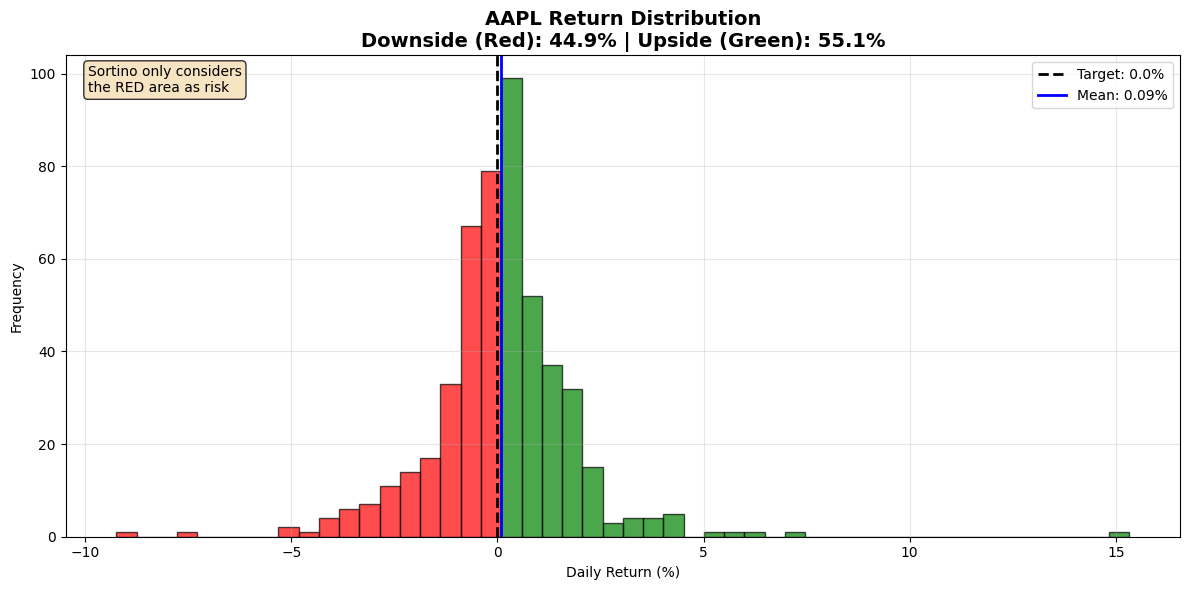

In [3]:
def plot_return_distribution(returns, ticker, target_return=0):
    """Visualize return distribution highlighting downside."""
    fig, ax = plt.subplots(figsize=(12, 6))

    returns_pct = returns * 100
    target_pct = target_return * 100

    # Histogram
    n, bins, patches = ax.hist(returns_pct, bins=50, alpha=0.7, edgecolor='black')

    # Color bars: red for below target, green for above
    for patch, left_edge in zip(patches, bins[:-1]):
        if left_edge < target_pct:
            patch.set_facecolor('red')
        else:
            patch.set_facecolor('green')

    # Add vertical line at target
    ax.axvline(target_pct, color='black', linestyle='--', linewidth=2,
               label=f'Target: {target_pct:.1f}%')

    # Add statistics
    mean_return = returns_pct.mean()
    ax.axvline(mean_return, color='blue', linestyle='-', linewidth=2,
               label=f'Mean: {mean_return:.2f}%')

    # Downside vs Upside
    downside_pct = (returns_pct < target_pct).sum() / len(returns_pct) * 100
    upside_pct = 100 - downside_pct

    ax.set_xlabel('Daily Return (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{ticker} Return Distribution\nDownside (Red): {downside_pct:.1f}% | Upside (Green): {upside_pct:.1f}%',
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    # Add text boxes
    textstr = f'Sortino only considers\nthe RED area as risk'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

# Visualize
plot_return_distribution(returns, ticker)

## Comparing Sharpe vs Sortino Across Investments

Some stocks look better under Sortino (asymmetric upside), others worse.

In [4]:
def compare_sharpe_sortino(tickers, period="2y"):
    """Compare Sharpe and Sortino ratios across investments."""
    results = []

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period=period)
            returns = hist['Close'].pct_change().dropna()

            metrics = calculate_sortino_ratio(returns)
            results.append({
                'ticker': ticker,
                'return_pct': metrics['annualized_return_pct'],
                'vol_pct': metrics['annualized_volatility_pct'],
                'downside_pct': metrics['downside_deviation_pct'],
                'sharpe': metrics['sharpe_ratio'],
                'sortino': metrics['sortino_ratio'],
                'sortino_sharpe_diff': metrics['sortino_ratio'] - metrics['sharpe_ratio']
            })
        except Exception as e:
            print(f"Error with {ticker}: {e}")

    return pd.DataFrame(results)

# Compare several investments
comparison_tickers = ["AAPL", "NVDA", "MSFT", "GOOGL", "JPM", "XOM", "SPY", "QQQ"]
comparison = compare_sharpe_sortino(comparison_tickers)

# Sort by Sortino-Sharpe difference (most favorable asymmetry first)
comparison = comparison.sort_values('sortino_sharpe_diff', ascending=False)

print("Sharpe vs Sortino Comparison")
print("=" * 80)
print(f"{'Ticker':<8} {'Return':>10} {'Vol':>10} {'Downside':>10} {'Sharpe':>10} {'Sortino':>10} {'Diff':>10}")
print("-" * 80)

for _, row in comparison.iterrows():
    diff_symbol = '+' if row['sortino_sharpe_diff'] > 0 else ''
    print(f"{row['ticker']:<8} {row['return_pct']:>9.1f}% {row['vol_pct']:>9.1f}% {row['downside_pct']:>9.1f}% "
          f"{row['sharpe']:>10.2f} {row['sortino']:>10.2f} {diff_symbol}{row['sortino_sharpe_diff']:>9.2f}")

print("-" * 80)
print("\nDiff > 0: More upside volatility than downside (favorable)")
print("Diff < 0: More downside volatility than upside (unfavorable)")

Sharpe vs Sortino Comparison
Ticker       Return        Vol   Downside     Sharpe    Sortino       Diff
--------------------------------------------------------------------------------
GOOGL         48.9%      29.8%      29.1%       1.64       1.68 +     0.04
NVDA          62.6%      50.8%      49.5%       1.23       1.27 +     0.03
AAPL          22.7%      28.1%      27.5%       0.81       0.83 +     0.02
MSFT           5.7%      23.5%      24.6%       0.24       0.23     -0.01
SPY           20.0%      16.3%      17.0%       1.22       1.17     -0.05
XOM           21.6%      21.9%      23.0%       0.99       0.94     -0.05
QQQ           21.9%      20.9%      22.0%       1.05       1.00     -0.05
JPM           33.9%      24.6%      26.3%       1.38       1.29     -0.09
--------------------------------------------------------------------------------

Diff > 0: More upside volatility than downside (favorable)
Diff < 0: More downside volatility than upside (unfavorable)


## Visualizing Sharpe vs Sortino

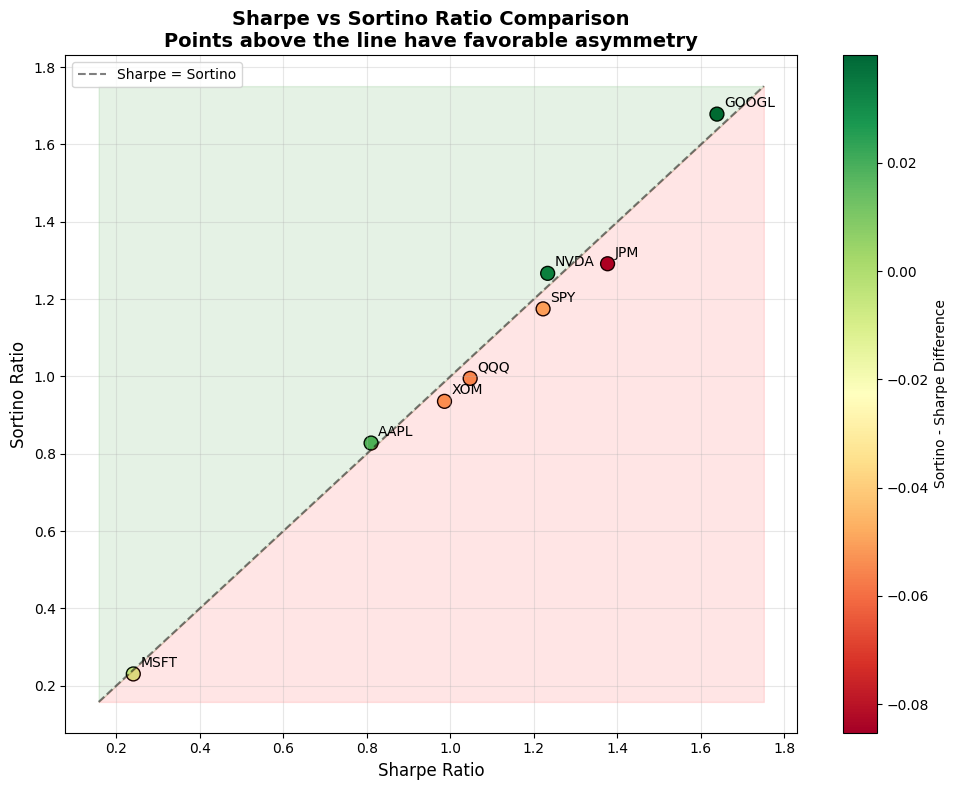

In [5]:
def plot_sharpe_vs_sortino(comparison_df):
    """Create scatter plot comparing Sharpe and Sortino ratios."""
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot
    scatter = ax.scatter(comparison_df['sharpe'], comparison_df['sortino'],
                        s=100, c=comparison_df['sortino_sharpe_diff'],
                        cmap='RdYlGn', edgecolors='black', linewidth=1)

    # Add labels for each point
    for _, row in comparison_df.iterrows():
        ax.annotate(row['ticker'], (row['sharpe'], row['sortino']),
                   xytext=(5, 5), textcoords='offset points', fontsize=10)

    # Add 45-degree line (where Sharpe = Sortino)
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
            max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='Sharpe = Sortino')

    # Labels and title
    ax.set_xlabel('Sharpe Ratio', fontsize=12)
    ax.set_ylabel('Sortino Ratio', fontsize=12)
    ax.set_title('Sharpe vs Sortino Ratio Comparison\nPoints above the line have favorable asymmetry',
                fontsize=14, fontweight='bold')

    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Sortino - Sharpe Difference')

    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')

    # Add regions
    ax.fill_between(lims, lims, [lims[1], lims[1]], alpha=0.1, color='green',
                   label='Favorable (more upside vol)')
    ax.fill_between(lims, [lims[0], lims[0]], lims, alpha=0.1, color='red',
                   label='Unfavorable (more downside vol)')

    plt.tight_layout()
    plt.show()

plot_sharpe_vs_sortino(comparison)

## When to Use Sortino vs Sharpe

| Use Sharpe When... | Use Sortino When... |
|-------------------|--------------------|
| Comparing diversified portfolios | Evaluating individual stocks |
| Returns are roughly symmetric | Returns are skewed |
| Volatility = risk in your context | Only downside matters |
| Industry standard required | More nuanced analysis needed |

**Best Practice:** Calculate both and compare. The difference tells you about asymmetry.

In [6]:
def full_risk_adjusted_analysis(ticker, period="2y"):
    """Comprehensive risk-adjusted return analysis."""
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    returns = hist['Close'].pct_change().dropna()

    # Basic metrics
    result = calculate_sortino_ratio(returns)

    # Additional skewness analysis
    from scipy import stats
    skewness = stats.skew(returns)
    kurtosis = stats.kurtosis(returns)

    print(f"Full Risk-Adjusted Analysis: {ticker}")
    print("=" * 55)
    print(f"\nReturn & Risk:")
    print(f"  Annualized Return:     {result['annualized_return_pct']:>8.1f}%")
    print(f"  Total Volatility:      {result['annualized_volatility_pct']:>8.1f}%")
    print(f"  Downside Deviation:    {result['downside_deviation_pct']:>8.1f}%")

    print(f"\nRisk-Adjusted Metrics:")
    print(f"  Sharpe Ratio:          {result['sharpe_ratio']:>8.2f}")
    print(f"  Sortino Ratio:         {result['sortino_ratio']:>8.2f}")

    print(f"\nDistribution Shape:")
    print(f"  Skewness:              {skewness:>8.2f}")
    if skewness > 0.5:
        print(f"    → Positive skew (more extreme gains)")
    elif skewness < -0.5:
        print(f"    → Negative skew (more extreme losses)")
    else:
        print(f"    → Roughly symmetric")

    print(f"  Kurtosis:              {kurtosis:>8.2f}")
    if kurtosis > 1:
        print(f"    → Fat tails (more extreme events than normal)")
    else:
        print(f"    → Normal-ish tails")

    print(f"\nRecommendation:")
    diff = result['sortino_ratio'] - result['sharpe_ratio']
    if diff > 0.3:
        print(f"  Sortino is significantly higher than Sharpe (+{diff:.2f})")
        print(f"  This investment has FAVORABLE asymmetry - more upside than downside.")
        print(f"  Sharpe UNDERSTATES the risk-adjusted return.")
    elif diff < -0.3:
        print(f"  Sortino is significantly lower than Sharpe ({diff:.2f})")
        print(f"  This investment has UNFAVORABLE asymmetry - more downside than upside.")
        print(f"  Sharpe OVERSTATES the risk-adjusted return.")
    else:
        print(f"  Sharpe and Sortino are similar (diff: {diff:.2f})")
        print(f"  The return distribution is relatively symmetric.")

# Full analysis
full_risk_adjusted_analysis("NVDA")

Full Risk-Adjusted Analysis: NVDA

Return & Risk:
  Annualized Return:         62.6%
  Total Volatility:          50.8%
  Downside Deviation:        49.5%

Risk-Adjusted Metrics:
  Sharpe Ratio:              1.23
  Sortino Ratio:             1.27

Distribution Shape:
  Skewness:                  0.21
    → Roughly symmetric
  Kurtosis:                  5.13
    → Fat tails (more extreme events than normal)

Recommendation:
  Sharpe and Sortino are similar (diff: 0.03)
  The return distribution is relatively symmetric.


## Portfolio Sortino Ratio

You can also calculate Sortino for an entire portfolio.

In [7]:
def calculate_portfolio_sortino(holdings, period="2y"):
    """Calculate Sortino ratio for a weighted portfolio.

    Args:
        holdings: Dict of {ticker: weight}
        period: Historical period
    """
    # Get returns for all holdings
    returns_dict = {}
    for ticker in holdings.keys():
        stock = yf.Ticker(ticker)
        hist = stock.history(period=period)
        returns_dict[ticker] = hist['Close'].pct_change().dropna()

    # Combine into DataFrame and align
    returns_df = pd.DataFrame(returns_dict).dropna()

    # Calculate portfolio returns
    portfolio_returns = pd.Series(0.0, index=returns_df.index)
    for ticker, weight in holdings.items():
        portfolio_returns += returns_df[ticker] * weight

    # Calculate Sortino for portfolio
    portfolio_metrics = calculate_sortino_ratio(portfolio_returns)

    # Also calculate individual Sortinos
    individual_metrics = {}
    for ticker in holdings.keys():
        individual_metrics[ticker] = calculate_sortino_ratio(returns_df[ticker])

    return {
        'portfolio': portfolio_metrics,
        'individual': individual_metrics,
        'portfolio_returns': portfolio_returns
    }

# Example portfolio
portfolio = {
    'AAPL': 0.25,
    'NVDA': 0.25,
    'JPM': 0.25,
    'XOM': 0.25
}

result = calculate_portfolio_sortino(portfolio)

print("Portfolio Sortino Analysis")
print("=" * 60)
print(f"\nIndividual Holdings:")
print(f"{'Ticker':<8} {'Weight':>10} {'Sharpe':>10} {'Sortino':>10}")
print("-" * 60)

for ticker, weight in portfolio.items():
    m = result['individual'][ticker]
    print(f"{ticker:<8} {weight*100:>9.0f}% {m['sharpe_ratio']:>10.2f} {m['sortino_ratio']:>10.2f}")

print("-" * 60)
pm = result['portfolio']
print(f"{'PORTFOLIO':<8} {'100':>9}% {pm['sharpe_ratio']:>10.2f} {pm['sortino_ratio']:>10.2f}")

# Compare to weighted average
weighted_avg_sortino = sum(
    portfolio[t] * result['individual'][t]['sortino_ratio']
    for t in portfolio.keys()
)

print(f"\nWeighted Avg Individual Sortino: {weighted_avg_sortino:.2f}")
print(f"Actual Portfolio Sortino:        {pm['sortino_ratio']:.2f}")
if pm['sortino_ratio'] > weighted_avg_sortino:
    print(f"\nDiversification improves downside-adjusted returns!")

Portfolio Sortino Analysis

Individual Holdings:
Ticker       Weight     Sharpe    Sortino
------------------------------------------------------------
AAPL            25%       0.81       0.83
NVDA            25%       1.23       1.27
JPM             25%       1.38       1.29
XOM             25%       0.99       0.94
------------------------------------------------------------
PORTFOLIO       100%       1.65       1.60

Weighted Avg Individual Sortino: 1.08
Actual Portfolio Sortino:        1.60

Diversification improves downside-adjusted returns!


## Key Takeaways

### Formulas You've Learned:

1. **Sortino Ratio** = (Return - Target) / Downside Deviation

2. **Downside Deviation** = √(mean of squared negative returns)

3. **Sortino - Sharpe Difference** tells you about return asymmetry

### Key Concepts:

- **Sharpe penalizes all volatility**, even upside surprises
- **Sortino only penalizes downside**, which better matches investor preferences
- **Positive skew = Sortino > Sharpe** (favorable)
- **Negative skew = Sortino < Sharpe** (unfavorable)

### When to Use Each:

- **Sharpe:** Standard benchmark comparison, diversified portfolios
- **Sortino:** Individual stock analysis, asymmetric strategies, options
- **Both:** Complete picture of risk-adjusted performance

### Why This Matters for AI Agents:

When we build AI agents, they'll need to:
- Calculate both Sharpe and Sortino to understand asymmetry
- Recommend investments with favorable downside characteristics
- Alert when Sortino drops significantly (increasing downside risk)
- Compare strategies using the appropriate metric

**Next Notebook:** We'll learn about sector analysis and concentration risk.